[before] mass[1:5]     = [3.66519143 4.05789051 2.7813567  5.31557477]
[before] dof_damping   = [0. 0. 0. 1. 1. 1.]
[before] foot friction = [2.e+00 5.e-03 1.e-04]
[after ] mass[1:5]     = [2.93215314 3.24631241 2.22508536 4.25245982]
[after ] dof_damping   = [0.  0.  0.  2.5 2.5 2.5]
[after ] foot friction = [3.e+00 5.e-03 1.e-04]


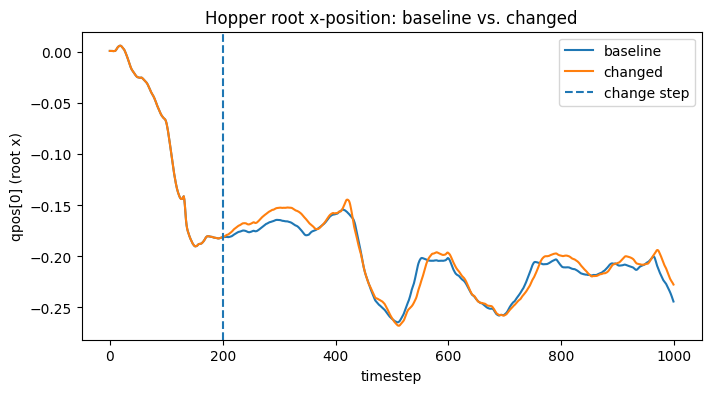

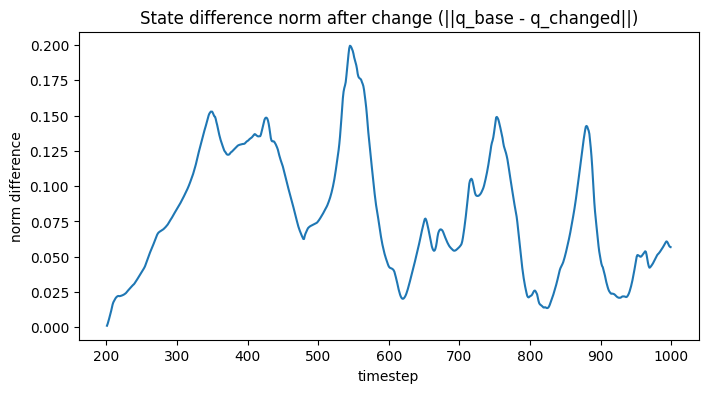

In [1]:
import numpy as np
import gymnasium as gym
import mujoco
import matplotlib.pyplot as plt

# ---------------------------
# Utilities
# ---------------------------

def apply_small_changes(env):
    """
    Apply small in-place physical parameter changes and refresh derived quantities.
    - Slightly reduce body masses (except world)
    - Slightly increase hinge joint damping
    - Slightly increase foot geom sliding friction
    Then call mj_forward to recompute derived quantities at the current state.
    """
    model = env.unwrapped.model
    data = env.unwrapped.data

    # 1) Body mass (exclude world at index 0)
    model.body_mass[1:] *= 0.8

    # 2) DOF damping (only hinge joints at indices 3:)
    model.dof_damping[3:] *= 2.5

    # 3) Foot geom friction (last geom is foot in Hopper XML)
    # geom_friction shape: [ngeom, 3] -> (slide, spin, roll)
    model.geom_friction[-1, 0] *= 1.5  # increase sliding friction a bit

    # Recompute derived quantities at the current state
    mujoco.mj_forward(model, data)


def rollout(env_id="Hopper-v5", T=1000, change_step=200, seed=0, change=False):
    """
    Run a rollout with a fixed action sequence.
    If `change=True`, apply small physical changes at `change_step`.
    Returns:
        qpos_trace: (L, nq) array of generalized positions
        rew_trace:  (L,) rewards
    """
    # Ensure the episode doesn't terminate early due to "unhealthy" checks
    env = gym.make(env_id, terminate_when_unhealthy=False)
    obs, info = env.reset(seed=seed)

    # Fixed action sequence for reproducibility
    rng = np.random.RandomState(0)
    act_dim = env.action_space.shape[0]
    actions = rng.uniform(-0.2, 0.2, size=(T, act_dim))

    qpos_list = []
    rew_list = []

    for t in range(T):
        if change and t == change_step:
            # Print before/after as a quick sanity check
            print("[before] mass[1:5]     =", env.unwrapped.model.body_mass[1:].copy())
            print("[before] dof_damping   =", env.unwrapped.model.dof_damping.copy())
            print("[before] foot friction =", env.unwrapped.model.geom_friction[-1].copy())
            apply_small_changes(env)
            print("[after ] mass[1:5]     =", env.unwrapped.model.body_mass[1:].copy())
            print("[after ] dof_damping   =", env.unwrapped.model.dof_damping.copy())
            print("[after ] foot friction =", env.unwrapped.model.geom_friction[-1].copy())

        obs, rew, terminated, truncated, info = env.step(actions[t])
        qpos_list.append(env.unwrapped.data.qpos.copy())
        rew_list.append(rew)
        if terminated or truncated:
            # Stop if the env decides to end (should be rare with terminate_when_unhealthy=False)
            break

    env.close()
    return np.array(qpos_list), np.array(rew_list)


# ---------------------------
# Experiment
# ---------------------------

T = 1000
change_step = 200

# Baseline (no physical change)
qpos_base, rew_base = rollout(T=T, change_step=change_step, change=False)

# With small mid-episode change
qpos_chg, rew_chg = rollout(T=T, change_step=change_step, change=True)

# Align lengths (in case one finishes earlier)
L = min(len(qpos_base), len(qpos_chg))
qpos_base = qpos_base[:L]
qpos_chg = qpos_chg[:L]
rew_base = rew_base[:L]
rew_chg = rew_chg[:L]

# Compute a simple scalar trajectory to visualize: e.g., root x-position (qpos[0])
rootx_base = qpos_base[:, 0]
rootx_chg  = qpos_chg[:, 0]

# Compute a normed difference after the change
if change_step < L - 1:
    diff_after = np.linalg.norm(qpos_base[change_step+1:] - qpos_chg[change_step+1:], axis=1)
else:
    diff_after = np.array([])

# ---------------------------
# Plots
# ---------------------------

# 1) Overlay root x-position trajectories
plt.figure(figsize=(8, 4))
plt.title("Hopper root x-position: baseline vs. changed")
plt.plot(rootx_base, label="baseline")
plt.plot(rootx_chg, label="changed")
plt.axvline(x=change_step, linestyle="--", label="change step")
plt.xlabel("timestep")
plt.ylabel("qpos[0] (root x)")
plt.legend()
plt.show()

# 2) Norm of state difference after the change
if diff_after.size > 0:
    plt.figure(figsize=(8, 4))
    plt.title("State difference norm after change (||q_base - q_changed||)")
    # Shift x-axis to start right after the change
    timesteps = np.arange(change_step + 1, change_step + 1 + len(diff_after))
    plt.plot(timesteps, diff_after)
    plt.xlabel("timestep")
    plt.ylabel("norm difference")
    plt.show()
else:
    print("No post-change timesteps to compare (episode ended before or at change_step).")